In [1]:
!pip3 install torchsummary
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from torchsummary import summary

In [2]:
"""
num_epochs = 100
batch_size = 512 #Smaller batch - better accuracy
image_height = 100
image_width = 100
num_channels = 3

train_dir = "/kaggle/input/fruits/fruits-360_dataset/fruits-360/Training"
test_dir = "/kaggle/input/fruits/fruits-360_dataset/fruits-360/Test"

transforms_data = transforms.Compose([ transforms.Resize((image_height, image_width)),
                                        transforms.ToTensor()
                                       ])

train_dataset = ImageFolder(train_dir, transform=transforms_data)
test_dataset = ImageFolder(test_dir, transform=transforms_data)
num_classes = len(train_dataset.classes)

dataloader_train = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
dataloader_test = DataLoader(test_dataset, batch_size=batch_size * 2, shuffle=False, pin_memory=True)

print('Train Dataset Size: ', len(train_dataset))
print('Test Dataset Size: ', len(test_dataset))
"""

'\nnum_epochs = 100\nbatch_size = 512 #Smaller batch - better accuracy\nimage_height = 100\nimage_width = 100\nnum_channels = 3\n\ntrain_dir = "/kaggle/input/fruits/fruits-360_dataset/fruits-360/Training"\ntest_dir = "/kaggle/input/fruits/fruits-360_dataset/fruits-360/Test"\n\ntransforms_data = transforms.Compose([ transforms.Resize((image_height, image_width)),\n                                        transforms.ToTensor()\n                                       ])\n\ntrain_dataset = ImageFolder(train_dir, transform=transforms_data)\ntest_dataset = ImageFolder(test_dir, transform=transforms_data)\nnum_classes = len(train_dataset.classes)\n\ndataloader_train = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)\ndataloader_test = DataLoader(test_dataset, batch_size=batch_size * 2, shuffle=False, pin_memory=True)\n\nprint(\'Train Dataset Size: \', len(train_dataset))\nprint(\'Test Dataset Size: \', len(test_dataset))\n'

In [3]:
"""
# python code to calculate mean and std 

from torch.utils.data import DataLoader

batch_size = 512

loader = DataLoader(
  train_dataset, 
  batch_size = batch_size, 
  num_workers=1)

def batch_mean_and_sd(loader):
    
    cnt = 0
    fst_moment = torch.empty(3)
    snd_moment = torch.empty(3)

    for images, _ in loader:
        b, c, h, w = images.shape
        nb_pixels = b * h * w
        sum_ = torch.sum(images, dim=[0, 2, 3])
        sum_of_square = torch.sum(images ** 2,
                                  dim=[0, 2, 3])
        fst_moment = (cnt * fst_moment + sum_) / (
                      cnt + nb_pixels)
        snd_moment = (cnt * snd_moment + sum_of_square) / (
                            cnt + nb_pixels)
        cnt += nb_pixels

    mean, std = fst_moment, torch.sqrt(
      snd_moment - fst_moment ** 2)        
    return mean,std
  
mean, std = batch_mean_and_sd(loader)
print("mean and std: \n", mean, std)
"""

'\n# python code to calculate mean and std \n\nfrom torch.utils.data import DataLoader\n\nbatch_size = 512\n\nloader = DataLoader(\n  train_dataset, \n  batch_size = batch_size, \n  num_workers=1)\n\ndef batch_mean_and_sd(loader):\n    \n    cnt = 0\n    fst_moment = torch.empty(3)\n    snd_moment = torch.empty(3)\n\n    for images, _ in loader:\n        b, c, h, w = images.shape\n        nb_pixels = b * h * w\n        sum_ = torch.sum(images, dim=[0, 2, 3])\n        sum_of_square = torch.sum(images ** 2,\n                                  dim=[0, 2, 3])\n        fst_moment = (cnt * fst_moment + sum_) / (\n                      cnt + nb_pixels)\n        snd_moment = (cnt * snd_moment + sum_of_square) / (\n                            cnt + nb_pixels)\n        cnt += nb_pixels\n\n    mean, std = fst_moment, torch.sqrt(\n      snd_moment - fst_moment ** 2)        \n    return mean,std\n  \nmean, std = batch_mean_and_sd(loader)\nprint("mean and std: \n", mean, std)\n'

In [4]:
num_epochs = 100
batch_size = 512 #Smaller batch - better accuracy
image_height = 100
image_width = 100
num_channels = 3

train_dir = "/kaggle/input/fruits/fruits-360_dataset/fruits-360/Training"
test_dir = "/kaggle/input/fruits/fruits-360_dataset/fruits-360/Test"

transforms_data = transforms.Compose([transforms.Resize((image_height, image_width)),
                                        transforms.ToTensor(),
                                     transforms.Normalize([0.6840, 0.5786, 0.5037], [0.3034, 0.3600, 0.3914]),

                                       ])

train_dataset = ImageFolder(train_dir, transform=transforms_data)
test_dataset = ImageFolder(test_dir, transform=transforms_data)
num_classes = len(train_dataset.classes)

dataloader_train = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
dataloader_test = DataLoader(test_dataset, batch_size=batch_size * 2, shuffle=False, pin_memory=True)

print('Train Dataset Size: ', len(train_dataset))
print('Test Dataset Size: ', len(test_dataset))

Train Dataset Size:  67692
Test Dataset Size:  22688


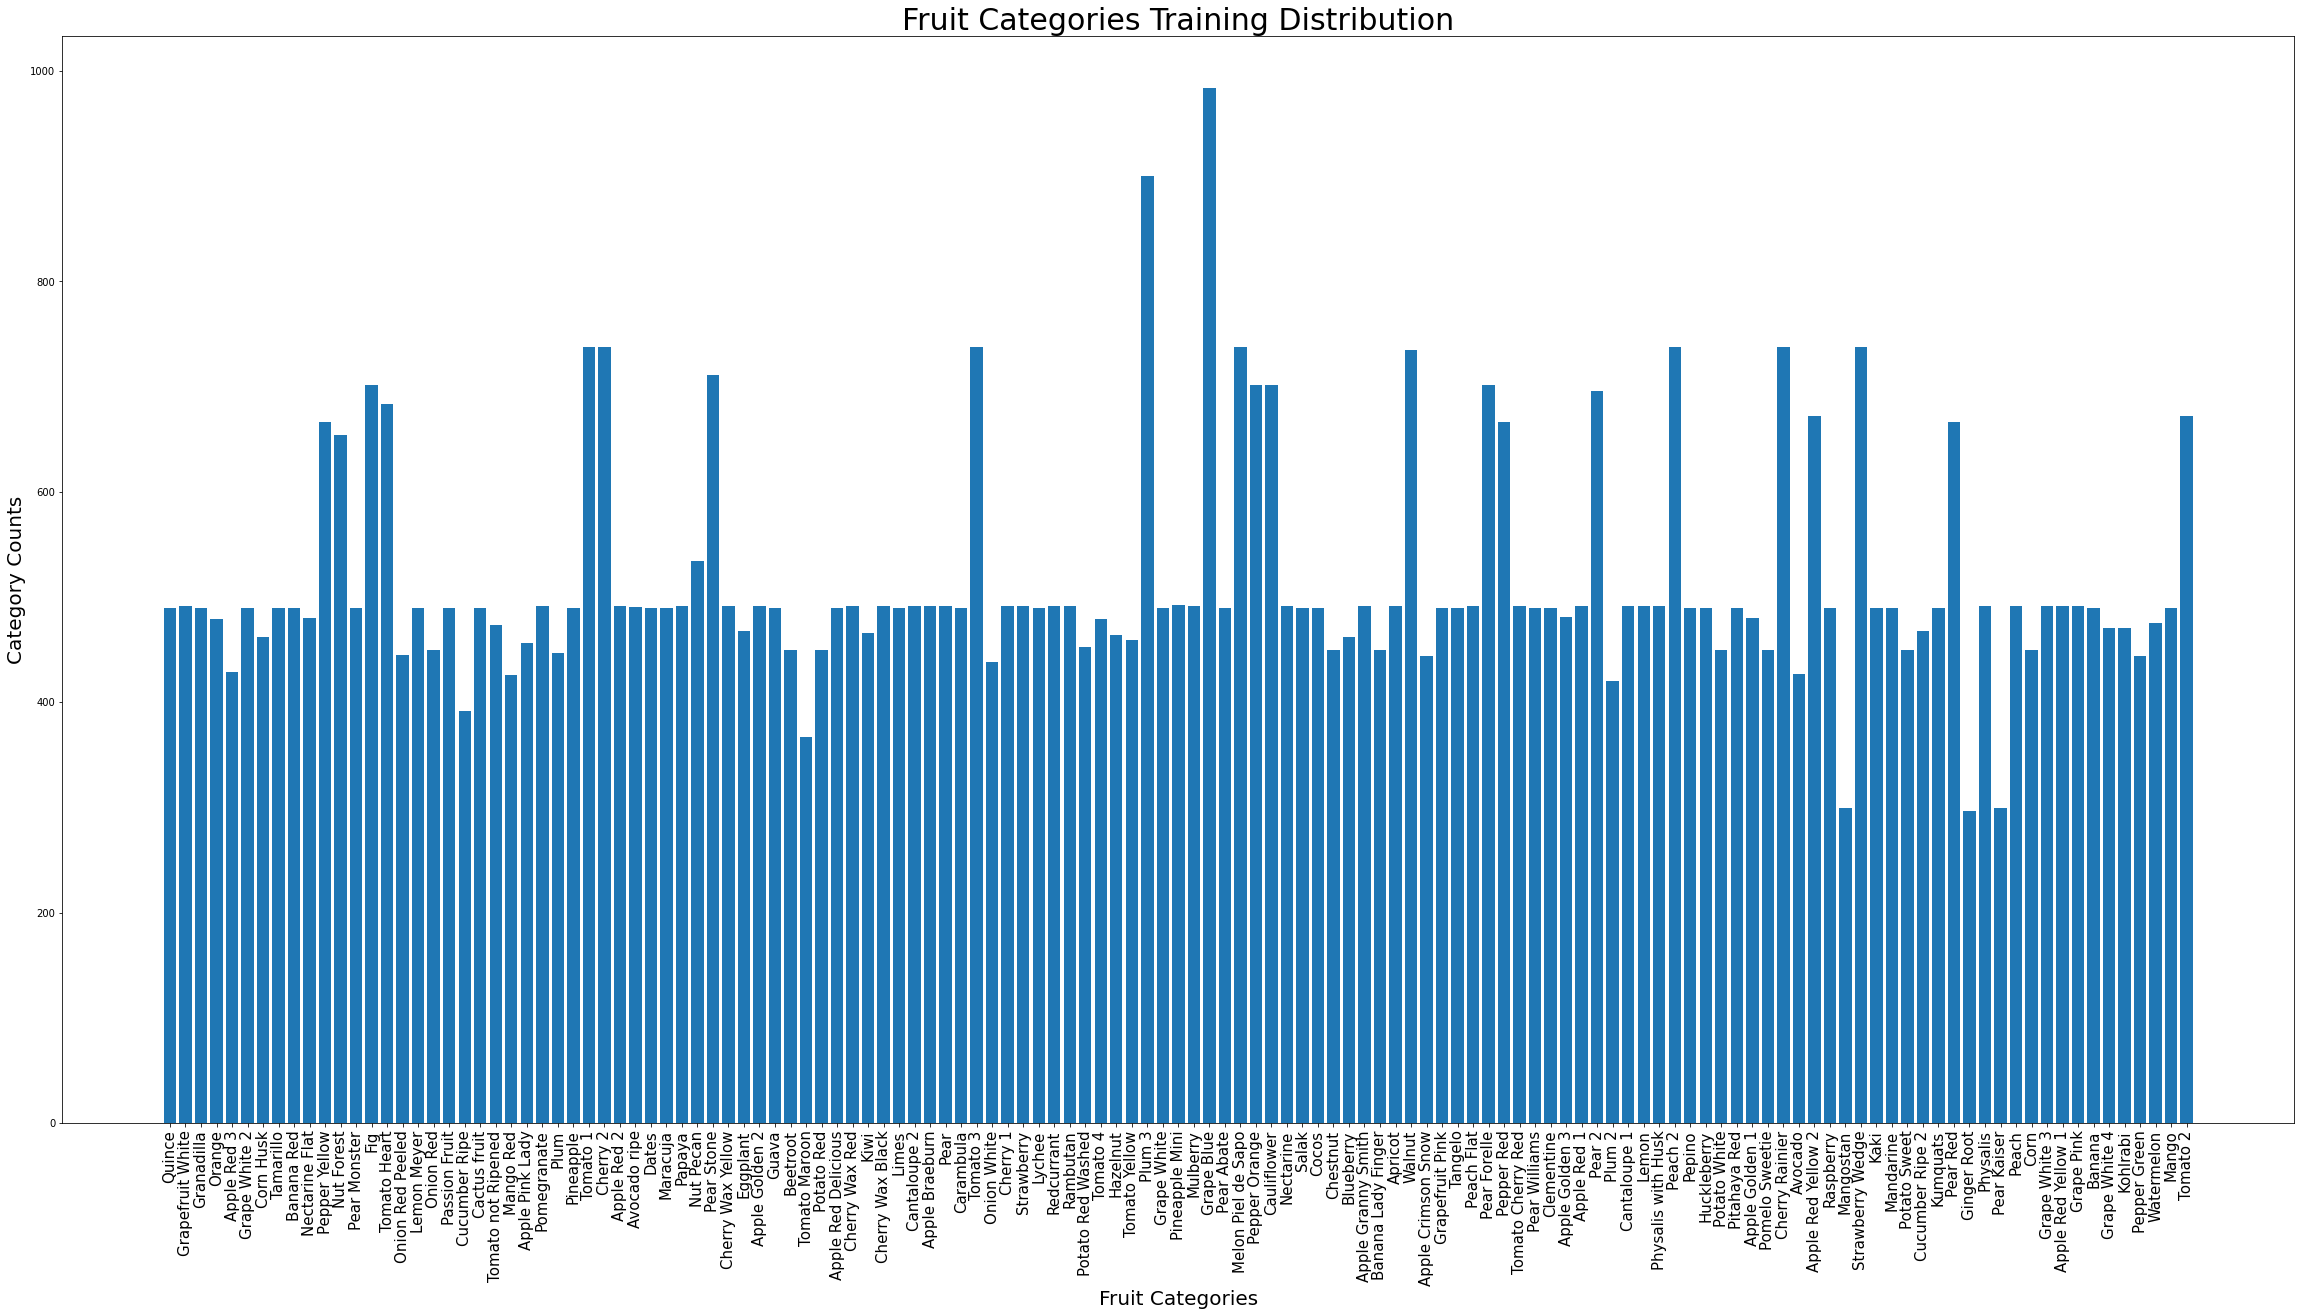

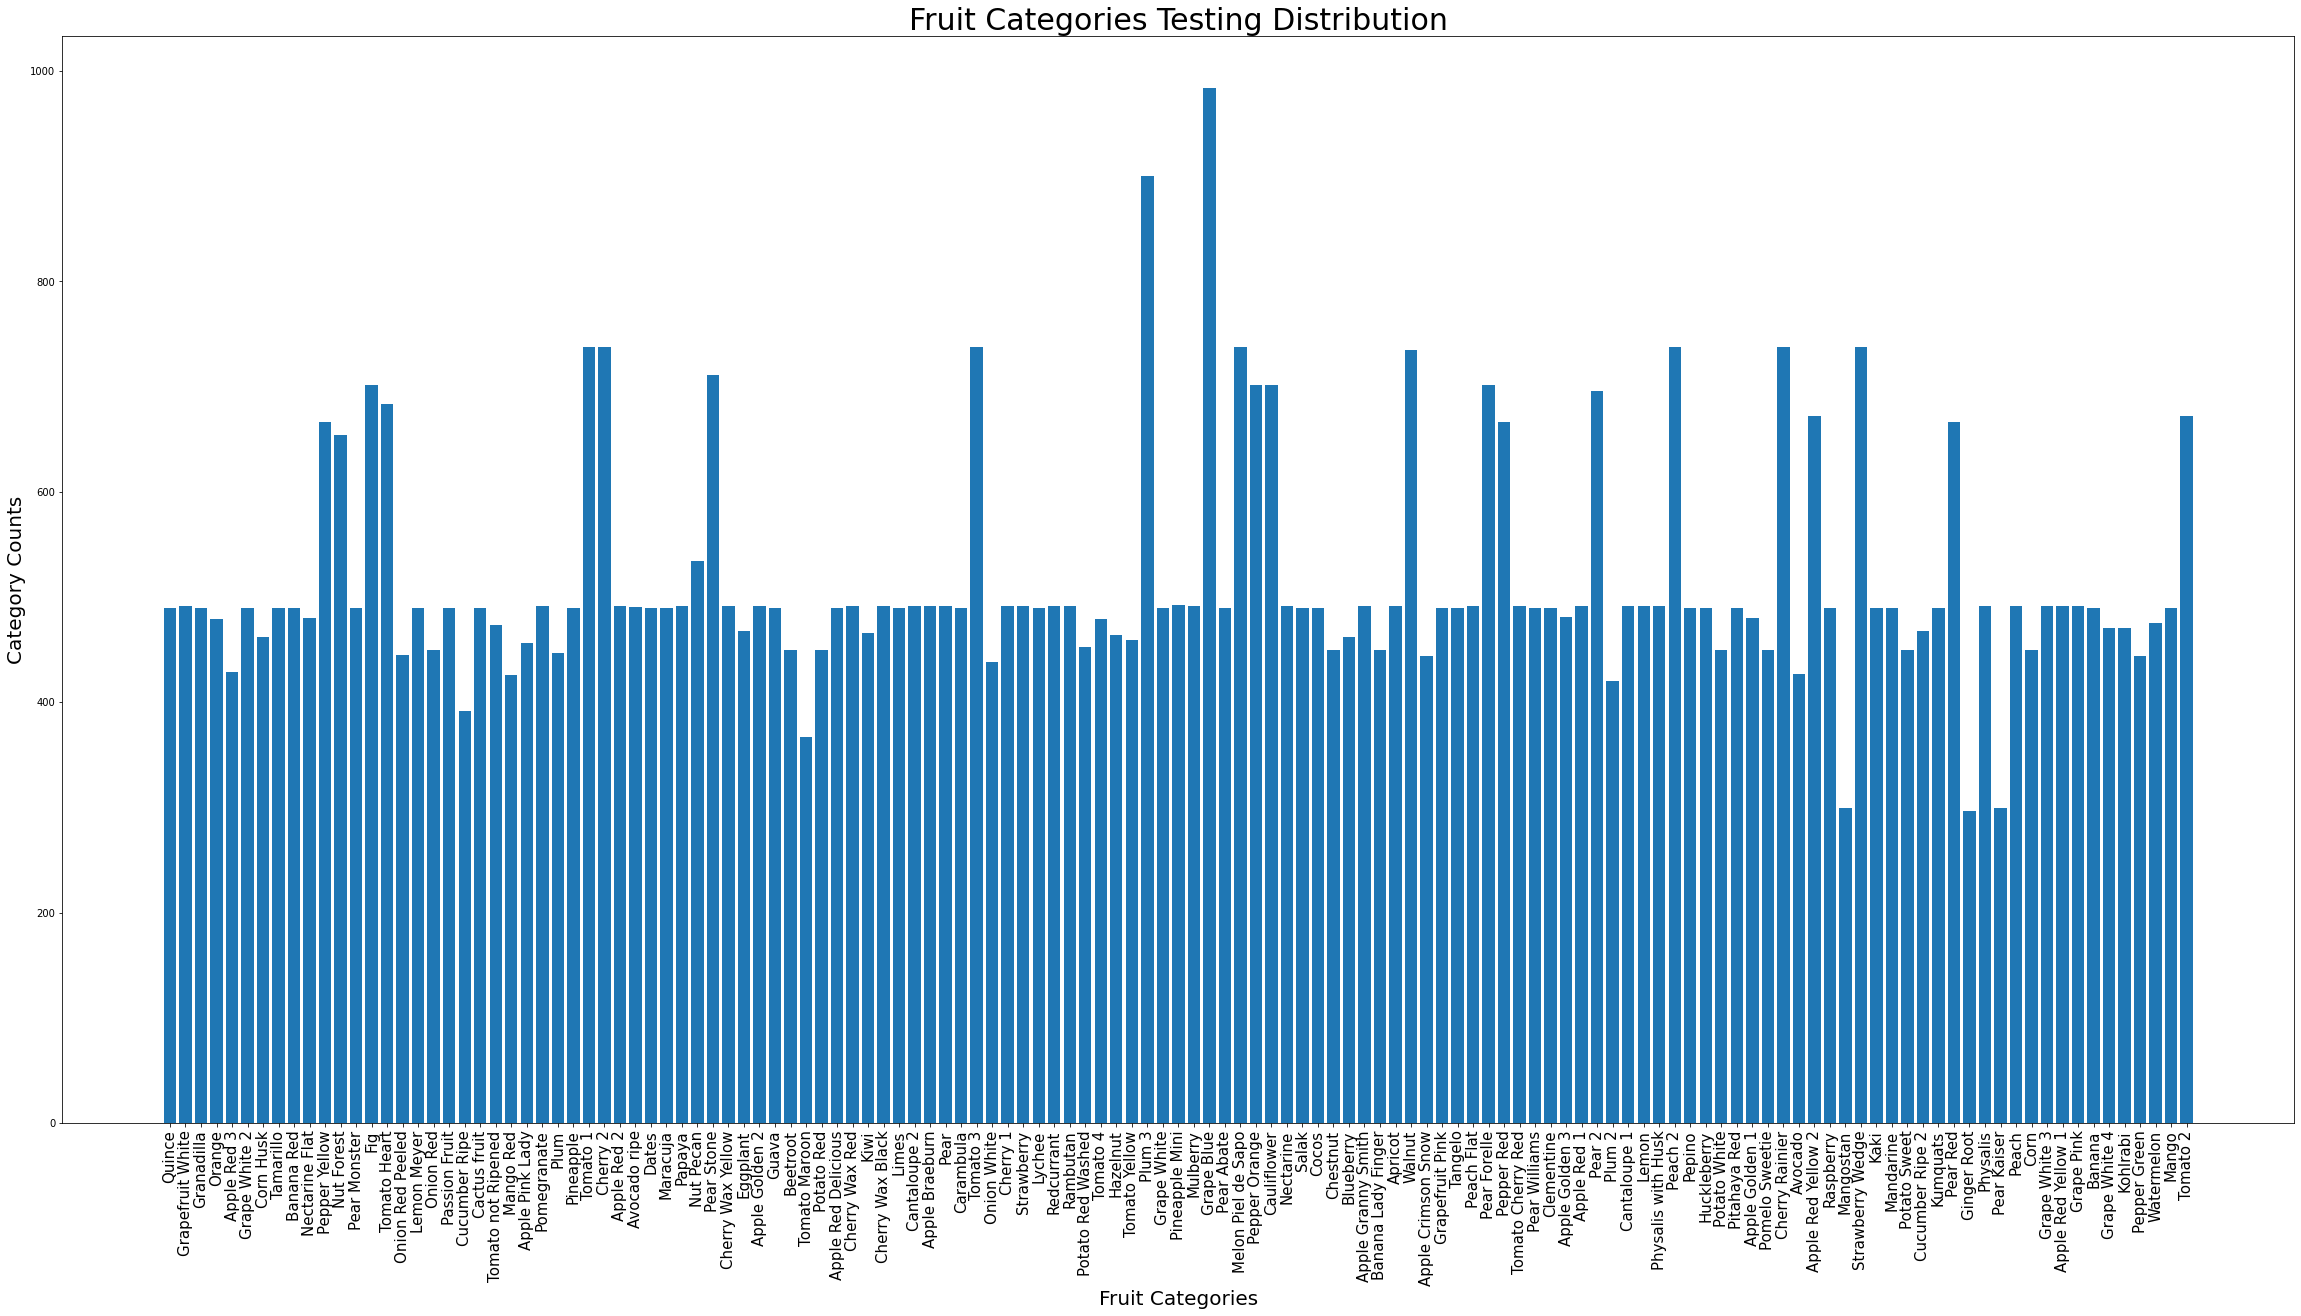

In [5]:
def plot_category_counts(path,xlabel,ylabel,title):
    categories = []
    counts = []
    for dir in os.listdir(path):
        categories.append(dir)
        counts.append(len(os.listdir(train_dir+"/"+ dir)))
    
    plt.rcParams["figure.figsize"] = (40,20)
    index = np.arange(len(categories))
    plt.bar(index, counts)
    plt.xlabel(xlabel, fontsize=20)
    plt.ylabel(ylabel, fontsize=20)
    plt.xticks(index, categories, fontsize=15, rotation=90)
    plt.title(title, fontsize=30)
    plt.show()

plot_category_counts(train_dir+"/",'Fruit Categories','Category Counts','Fruit Categories Training Distribution')
plot_category_counts(test_dir+"/",'Fruit Categories','Category Counts','Fruit Categories Testing Distribution')

In [6]:
num_classes = len(train_dataset.classes)

class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()

        #I will try to explain size changes here
        #We initiate with tensor 3 x 100 x 100 - channels x pixels x pixels
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=5,stride = 1,padding ='same') #padding same keeps the same size
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2) #kernel_size 2 decreses every square 2 x 2 to one value
        #after this layer we will have 16 x 50 x 50  - 16 because conv 2d changed channels to 16 convolutions(?)
        #channels are colors RGB -> 3 channels, black/white -> 1 channel
        
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=4, stride=1, padding='same')
        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        #We change channels from 16 to 32 and again half pixels, so 32 x 25 x 25
        
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding='same')
        self.maxpool3 = nn.MaxPool2d(kernel_size=5, stride=5)
        #This time we double channels and decrease pixels five-folds, so 64 x 5 x 5
        
        #After that we will switch to linear layers, this means we will have to flatten the dimensionality from 3d to 1d
        #This gives us 64*5*5 = 1600
        #later with linear, the swapping is quite intuitive
        
        self.d1 = nn.Linear(1600, 512)
        self.d2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.maxpool1(x)

        x = self.conv2(x)
        x = F.relu(x)
        x = self.maxpool2(x)
        
        x = self.conv3(x)
        x = F.relu(x)
        x = self.maxpool3(x)
        
        x = x.flatten(start_dim = 1)
        
        # 32 x (32*26*26) => 32x128
        x = self.d1(x)
        x = F.relu(x)
        
        # logits => 32x10
        logits = self.d2(x)
        out = F.softmax(logits, dim=1)
        return out

In [7]:
model = MyModel()
summary(model, (3, 100, 100),device="cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 100, 100]           1,216
         MaxPool2d-2           [-1, 16, 50, 50]               0
            Conv2d-3           [-1, 32, 50, 50]           8,224
         MaxPool2d-4           [-1, 32, 25, 25]               0
            Conv2d-5           [-1, 64, 25, 25]          18,496
         MaxPool2d-6             [-1, 64, 5, 5]               0
            Linear-7                  [-1, 512]         819,712
            Linear-8                  [-1, 131]          67,203
Total params: 914,851
Trainable params: 914,851
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.11
Forward/backward pass size (MB): 2.61
Params size (MB): 3.49
Estimated Total Size (MB): 6.22
----------------------------------------------------------------


/opt/conda/lib/python3.7/site-packages/torch/nn/modules/conv.py:444: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at  /usr/local/src/pytorch/aten/src/ATen/native/Convolution.cpp:743.)
  self.padding, self.dilation, self.groups)


In [8]:
## test the model with 1 batch
model = MyModel()
for images, labels in dataloader_train:
    print("batch size:", images.shape)
    out = model(images)
    print(out.shape)
    break

batch size: torch.Size([512, 3, 100, 100])
torch.Size([512, 131])


In [9]:
learning_rate = 0.001
num_epochs = 100


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = MyModel()
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [11]:
CUDA = torch.cuda.is_available()
if CUDA:
    print(f"Using GPU")

Using GPU


In [ ]:
from datetime import datetime
import math
loss_fn = nn.CrossEntropyLoss()
train_loss = []
test_loss = []
train_accuracy = []
test_accuracy = []

print('Start Training')
print('*'*100)

for epoch in range(num_epochs):
    start_time = datetime.now()

    # TRAINING
    correct = 0
    iterations = 0
    iter_loss = 0.0

    model.train()
    for i, (inputs, labels) in enumerate(dataloader_train):
        if CUDA:
            inputs = inputs.cuda()
            labels = labels.cuda()

        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        iter_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum()
        iterations += 1

    train_loss.append(iter_loss / iterations)
    train_accuracy.append(100 * correct / len(train_dataset))

    # TESTING
    loss_testing = 0.0
    correct = 0
    iterations = 0

    model.eval()

    for i, (inputs, labels) in enumerate(dataloader_test):
        if CUDA:
            inputs = inputs.cuda()
            labels = labels.cuda()

        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        loss_testing += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum()

        iterations += 1

    test_loss.append(loss_testing / iterations)
    test_accuracy.append(100 * correct / len(test_dataset))

    print('Epoch {}/{}, Training Loss: {:.3f}, Training Accuracy: {:.3f}, Testing Loss: {:.3f}, Testing Acc: {:.3f}'
          .format(epoch + 1, num_epochs, train_loss[-1], train_accuracy[-1], test_loss[-1], test_accuracy[-1]))

    end_time = datetime.now()
    epoch_time = (end_time - start_time).total_seconds()
    print("-"*100)
    print('Epoch Time : ', math.floor(epoch_time // 60), ':', math.floor(epoch_time % 60))
    print("-"*100)
    
print("*** Training Completed ***")

Start Training
****************************************************************************************************
Epoch 1/100, Training Loss: 4.721, Training Accuracy: 16.906, Testing Loss: 4.694, Testing Acc: 20.182
----------------------------------------------------------------------------------------------------
Epoch Time :  11 : 19
----------------------------------------------------------------------------------------------------
Epoch 2/100, Training Loss: 4.668, Training Accuracy: 22.014, Testing Loss: 4.685, Testing Acc: 21.121
----------------------------------------------------------------------------------------------------
Epoch Time :  4 : 22
----------------------------------------------------------------------------------------------------
Epoch 3/100, Training Loss: 4.659, Training Accuracy: 22.864, Testing Loss: 4.671, Testing Acc: 22.505
----------------------------------------------------------------------------------------------------
Epoch Time :  4 : 11
------

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(8,4), dpi=120)

# Loss
ax[0].plot(train_loss, label='Training Loss')
ax[0].plot(test_loss, label='Testing Loss')
ax[0].axis(ymin=-0.10, ymax=10)
ax[0].set_title('Loss Plot')
ax[0].legend()

# Accuracy
ax[1].plot(train_accuracy, label='Training Accuracy')
ax[1].plot(test_accuracy, label='Testing Accuracy')
ax[1].axis(ymin=0, ymax=101)
ax[1].set_title('Accuracy Plot')
ax[1].legend()
plt.show()